In [ ]:
from os.path import basename, isfile, join, splitext

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from insightface_func.face_detect_crop_single import Face_detect_crop
from models.models import create_model
from options.test_options import TestOptions

import os
import shutil
from os.path import basename, exists, isfile, join, splitext

import cv2
import numpy as np
import torch
from tqdm import tqdm

from util.videoswap import lower_resolution, extract_audio, get_frames_n, _totensor

import warnings
warnings.filterwarnings('ignore')

from face_seg.nets.MobileNetV2_unet import MobileNetV2_unet

seg_model = MobileNetV2_unet(None).to('cuda')
state_dict = torch.load('face_seg/checkpoints/model.pt', map_location='cpu')
seg_model.load_state_dict(state_dict)
seg_model.eval();

model, app = None, None
transformer_Arcface = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


opt = TestOptions()
opt.initialize()
opt.parser.add_argument('-f')  # dummy arg to avoid bug
opt = opt.parse()
opt.Arc_path = './arcface_model/arcface_checkpoint.tar'
opt.isTrain = False
torch.nn.Module.dump_patches = True
global model
model = create_model(opt)
model.eval()
global app
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id=0, det_thresh=0.6, det_size=(256, 256))

source = '../reference_videos/gen_0.jpg'
target = '../reference_videos/stocks/man_2.mp4'
result_dir='./output'
crop_size=224


assert isfile(source), f'Can\'t find source at {source}'
assert isfile(target), f'Can\'t find target at {target}'
output_filename = f'infer-{splitext(basename(source))[0]}-{splitext(basename(target))[0]}.mp4'
output_path = join(result_dir, output_filename)

assert model is not None
assert app is not None

img_a_whole = cv2.imread(source)
img_a_align_crop, _ = app.get(img_a_whole, crop_size)
img_a_align_crop_pil = Image.fromarray(
    cv2.cvtColor(img_a_align_crop[0], cv2.COLOR_BGR2RGB))
img_a = transformer_Arcface(img_a_align_crop_pil)
img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])
img_id = img_id.cuda()

img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
latend_id = model.netArc(img_id_downsample)
latend_id = latend_id.detach().to('cpu')
latend_id = latend_id / np.linalg.norm(latend_id, axis=1, keepdims=True)
latend_id = latend_id.to('cuda')

In [ ]:
# # os.environ['BASICSR_JIT'] = 'True'


# from GFPGAN.archs.gfpganv1_arch import GFPGANv1

# gfpgan = GFPGANv1(
#         out_size=512,
#         num_style_feat=512,
#         channel_multiplier=1,
#         decoder_load_path=None,
#         fix_decoder=True,
#         num_mlp=8,
#         input_is_latent=True,
#         different_w=True,
#         narrow=1,
#         sft_half=True)

# gfpgan.to('cuda')
# checkpoint = torch.load('weights/GFPGANv1.pth', map_location=lambda storage, loc: storage)
# gfpgan.load_state_dict(checkpoint['params_ema'])
# gfpgan.eval();

In [ ]:
from fsr.models.SRGAN_model import SRGANModel
import torchvision.transforms as transforms
import easydict


_transform = transforms.Compose([transforms.Resize((128, 128)),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                      std=[0.5, 0.5, 0.5])])

args = easydict.EasyDict({
    'gpu_ids': None,
    'batch_size': 32,
    'lr_G': 1e-4,
    'weight_decay_G': 0,
    'beta1_G': 0.9,
    'beta2_G': 0.99,
    'lr_D': 1e-4,
    'weight_decay_D': 0,
    'beta1_D': 0.9,
    'beta2_D': 0.99,
    'lr_scheme': 'MultiStepLR',
    'niter': 100000,
    'warmup_iter': -1,
    'lr_steps': [50000],
    'lr_gamma': 0.5,
    'pixel_criterion': 'l1',
    'pixel_weight': 1e-2,
    'feature_criterion': 'l1',
    'feature_weight': 1,
    'gan_type': 'ragan',
    'gan_weight': 5e-3,
    'D_update_ratio': 1,
    'D_init_iters': 0,

    'print_freq': 100,
    'val_freq': 1000,
    'save_freq': 10000,
    'crop_size': 0.85,
    'lr_size': 128,
    'hr_size': 512,

    # network G
    'which_model_G': 'RRDBNet',
    'G_in_nc': 3,
    'out_nc': 3,
    'G_nf': 64,
    'nb': 16,

    # network D
    'which_model_D': 'discriminator_vgg_128',
    'D_in_nc': 3,
    'D_nf': 64,

    # data dir
    'pretrain_model_G': 'weights/90000_G.pth',
    'pretrain_model_D': None
})


sr_model = SRGANModel(args, is_train=False)
sr_model.load()
sr_model.netG.to('cuda')
sr_model.netG.eval();

=> Swapping face in "../reference_videos/stocks/man_2.mp4"...
=> Extracting audio from video "man_2.mp4"...
> > > > > Unable to extract audio of ../reference_videos/stocks/man_2.mp4 (2021-07-20 22:52:26.935508).
> Time elapsed on `Extracting audio`: 00:00:00 (2021-07-20 22:52:27.039320).


Output file #0 does not contain any stream
0it [00:00, ?it/s]2021-07-20 22:52:28.196142990 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,10} does not match actual shape of {128,10} for output 500
2021-07-20 22:52:28.196215088 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,4} does not match actual shape of {128,4} for output 497
2021-07-20 22:52:28.196244387 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,1} does not match actual shape of {128,1} for output 494
2021-07-20 22:52:28.196835868 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,10} does not match actual shape of {512,10} for output 477
2021-07-20 22:52:28.196901866 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,4} does not match actual shape of {512,4} for output 474
2021-07-20 22:52:28.196959764 [W:

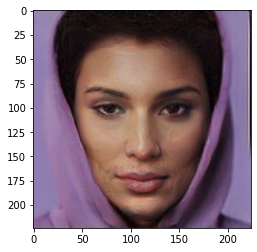

swaped_img
[[ 4.48806012e+00 -3.15979159e-02  8.31182693e+01]
 [ 3.15979159e-02  4.48806012e+00  4.52456141e+02]]


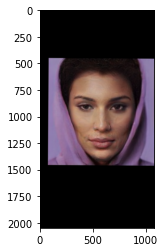

target_image


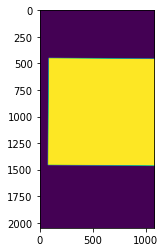

img_white


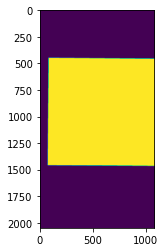

img_white
(2048, 1080)


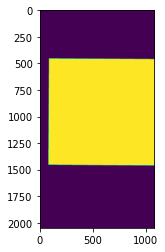

img_mask
(2048, 1080, 1)


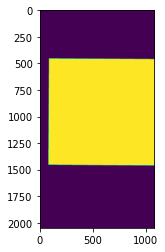

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_mask


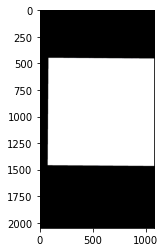

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target_image


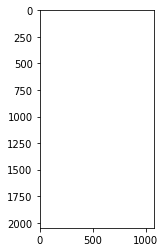

img


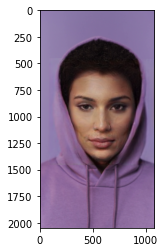

1it [00:02,  2.98s/it]

final_img-RGB


In [27]:
import matplotlib.pyplot as plt
from scipy.special import expit
from torchvision.transforms.functional import normalize


def reverse2wholeimage(swaped_imgs, mats, crop_size, oriimg, save_path=''):
    target_image_list = []
    img_mask_list = []
    for swaped_img, mat in zip(swaped_imgs, mats):
        
        # swaped_img_sr = _transform(torch.clone(swaped_img))
        # plt.imshow(swaped_img_sr.cpu().detach().numpy().transpose((1, 2, 0))); plt.show(); print('swaped_img_sr') ###

        # with torch.no_grad():
        #     swaped_img_sr = sr_model.netG(swaped_img_sr.unsqueeze(0))
        # print(swaped_img_sr.shape)
        # plt.imshow(swaped_img_sr.squeeze(0).cpu().detach().numpy().transpose((1, 2, 0))); plt.show(); print('swaped_img_sr') ###

        # swaped_img = F.interpolate(swaped_img_sr, (crop_size, crop_size), mode='area') 
        # print(swaped_img.shape)
        # swaped_img = swaped_img.squeeze(0).cpu().detach().numpy().transpose((1, 2, 0))
        # swaped_img = swaped_img / 2.0 + 0.5
        # # swaped_img = np.clip((swaped_img / 2.0 + 0.5) * 255.0, 0, 255).astype(np.uint8)
        # print(swaped_img.shape)
        # plt.imshow(swaped_img); plt.show(); print('swaped_img') ###

        # seg_mask_logits = seg_model(swaped_img.unsqueeze(0))
        # seg_mask = seg_mask_logits.cpu().detach().numpy().squeeze()
        # seg_mask  = seg_mask.transpose((1, 2, 0))
        # plt.imshow(seg_mask); plt.show(); print('seg_mask') ###

        # sigm_ = expit(seg_mask[:, :, 1])
        # print(sigm_.shape, sigm_.min(), sigm_.max())
        # plt.imshow(sigm_); plt.show(); print('seg_mask') ###
        # plt.imshow(sigm_ > 0.5); plt.show(); print('seg_mask 0.5') ###
        # plt.imshow(sigm_ > 0.6); plt.show(); print('seg_mask 0.6') ###
        # plt.imshow(sigm_ > 0.7); plt.show(); print('seg_mask 0.7') ###
        # plt.imshow(sigm_ > 0.8); plt.show(); print('seg_mask 0.8') ###

        # seg_mask = np.argmax(seg_mask, axis=2) == 1

        # plt.imshow(sigm_ * seg_mask); plt.show(); print('sigm_ * seg_mask') ###
        # plt.imshow(sigm_ * (seg_mask > 0.5)); plt.show(); print('sigm_ * seg_mask 0.5') ###
        # plt.imshow(sigm_ * (seg_mask > 0.6)); plt.show(); print('sigm_ * seg_mask 0.6') ###
        # plt.imshow(sigm_ * (seg_mask > 0.7)); plt.show(); print('sigm_ * seg_mask 0.7') ###
        # plt.imshow(sigm_ * (seg_mask > 0.8)); plt.show(); print('sigm_ * seg_mask 0.8') ###

        # img_white = seg_mask * 255
        # img_white = np.array(img_white, dtype=float)
        # print(img_white.shape, np.unique(img_white), type(img_white))

        img_white = np.full((crop_size, crop_size), 255, dtype=float)

        swaped_img = swaped_img.cpu().detach().numpy().transpose((1, 2, 0))
        plt.imshow(swaped_img); plt.show(); print('swaped_img') ###
        cv2.imwrite(splitext(save_path)[0] + '_' + splitext(save_path)[1], cv2.cvtColor(swaped_img * 255, cv2.COLOR_BGR2RGB))

        mat_rev = np.zeros([2, 3])
        div1 = mat[0][0]*mat[1][1]-mat[0][1]*mat[1][0]
        mat_rev[0][0] = mat[1][1]/div1
        mat_rev[0][1] = -mat[0][1]/div1
        mat_rev[0][2] = -(mat[0][2]*mat[1][1]-mat[0][1]*mat[1][2])/div1
        div2 = mat[0][1]*mat[1][0]-mat[0][0]*mat[1][1]
        mat_rev[1][0] = mat[1][0]/div2
        mat_rev[1][1] = -mat[0][0]/div2
        mat_rev[1][2] = -(mat[0][2]*mat[1][0]-mat[0][0]*mat[1][2])/div2

        print(mat_rev)

        orisize = (oriimg.shape[1], oriimg.shape[0])
        target_image = cv2.warpAffine(swaped_img, mat_rev, orisize)
        plt.imshow(target_image); plt.show(); print('target_image') ###
        img_white = cv2.warpAffine(img_white, mat_rev, orisize)
        plt.imshow(img_white); plt.show(); print('img_white') ###

        img_white[img_white > 20] = 255
        plt.imshow(img_white); plt.show(); print('img_white') ###

        img_mask = img_white

        kernel = np.ones((10, 10), np.uint8)
        img_mask = cv2.erode(img_mask, kernel, iterations=1)
        print(img_mask.shape)
        plt.imshow(img_mask); plt.show(); print('img_mask') ###

        img_mask /= 255

        img_mask = np.reshape(img_mask, [img_mask.shape[0], img_mask.shape[1], 1])
        print(img_mask.shape)
        plt.imshow(img_mask); plt.show(); print('img_mask') ###
        target_image = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        plt.imshow(target_image); plt.show(); print('target_image') ###

        img_mask_list.append(img_mask)
        target_image_list.append(target_image)

    img = np.array(oriimg, dtype=np.float64)
    for img_mask, target_image in zip(img_mask_list, target_image_list):
        img = img_mask * target_image + (1-img_mask) * img
    plt.imshow(img); plt.show(); print('img') ###

    final_img = img.astype(np.uint8)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)); plt.show(); print('final_img-RGB') ###

    cv2.imwrite(save_path, final_img)


video_path = target
temp_results_dir='./temp_results'
swap_model = model
detect_model = app
id_veсtor = latend_id

lower_resolution(video_path)
print(f'=> Swapping face in "{video_path}"...')
if exists(temp_results_dir):
    shutil.rmtree(temp_results_dir)
os.makedirs(temp_results_dir)

audio_path = join(temp_results_dir, splitext(basename(video_path))[0] + '.wav')
extract_audio(video_path, audio_path)

frame_count = get_frames_n(video_path)

video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)

for i, frame_index in tqdm(enumerate(range(frame_count))): 
    if i > 0:
        break
    _, frame = video.read()
    detect_results = detect_model.get(frame, crop_size)     

    if detect_results is not None:
        frame_align_crop_list = detect_results[0]
        frame_mat_list = detect_results[1]
        swap_result_list = []

        for frame_align_crop in frame_align_crop_list:
            frame_align_crop_tensor = _totensor(cv2.cvtColor(frame_align_crop,cv2.COLOR_BGR2RGB))[None,...].cuda()

            swap_result = swap_model(None, frame_align_crop_tensor, id_veсtor, None, True)[0]
            swap_result_list.append(swap_result)
        reverse2wholeimage(swap_result_list, frame_mat_list, crop_size, frame, join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)))
    else:
        frame = frame.astype(np.uint8)
        cv2.imwrite(join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)), frame)